<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Отчёт-по-исследованию" data-toc-modified-id="Отчёт-по-исследованию-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Отчёт по исследованию</a></span></li></ul></div>

# Проект: модель для классификации комментариев с BERT

Описание задачи: интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Наша цель - обучить модель классифицировать комментарии на позитивные и негативные, используя набор данных с разметкой о токсичности правок.
Необходимо построить модель со значением метрики качества F1 не меньше 0.75

## Загрузка и подготовка данных

Загрузим необходимые библиотеки:

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import transformers
from tqdm import notebook
import torch

from sklearn.model_selection import train_test_split, cross_val_score, \
                                    GridSearchCV
from sklearn.metrics import f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [7]:
! pip install lightgbm
from lightgbm import LGBMClassifier, LGBMRegressor

In [8]:
TEST_SIZE = 0.25
RANDOM_STATE = 1897

In [10]:
# загрузка файла данных из GD:
! gdown 1yo-43iCpgxdZGTLxR1eOFFbbtODURe4Y

Downloading...
From: https://drive.google.com/uc?id=1yo-43iCpgxdZGTLxR1eOFFbbtODURe4Y
To: /content/toxic_comments.csv
100% 65.0M/65.0M [00:00<00:00, 68.1MB/s]


In [11]:
data = pd.read_csv('/content/toxic_comments.csv', index_col=[0], \
                   parse_dates=[0])

<ipython-input-11-78ed62c1808e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('/content/toxic_comments.csv', index_col=[0], \
<ipython-input-11-78ed62c1808e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('/content/toxic_comments.csv', index_col=[0], \


In [ ]:
# для Jupyter Notebook:

#path_1 = 'toxic_comments.csv'
#path_2 = '/datasets/toxic_comments.csv'

#if os.path.exists(path_1):
#    data = pd.read_csv(path_1)
#elif os.path.exists(path_2):
#    data = pd.read_csv(path_2)
#else:
#    print('Something is wrong!')

In [12]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Датасет содержит всего два признака:

- `text` - текст комментария
- `toxic` - целевой признак, является комментарий позитивным (0) или негативным (1)

In [13]:
# проверим датасет на пропущенные значения:
data.isna().sum()

,0
text,0
toxic,0


Пропущенные значения отсутствуют

In [14]:
# проверим датасет на явные дубликаты:
data.index.duplicated().sum()

np.int64(0)

Явные дубликаты отсутствуют

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.7+ MB


Всего датасет содержит 159292 строки. Посмотрим, как распределён целевой признак `toxic`:

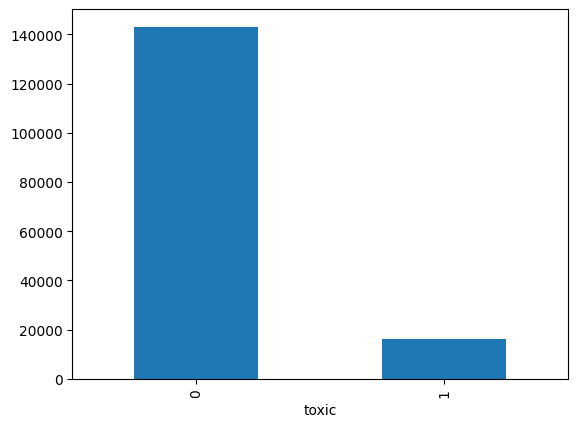

In [16]:
data['toxic'].value_counts().plot(kind='bar')
plt.show()

Наблюдаем дисбаланс классов, а значит при разделении на тренировочную и тестовую выборки применим стратификацию

In [17]:
# поскольку решили использовать модель BERT, а датасет слишком большой
# для обработки на локальной машине, возьмём выборку из 2000 записей
data_sample = data.sample(2000, random_state=RANDOM_STATE)

In [18]:
# токенизируем текст, используя версию BERT unitary/toxic-bert,
# так как она обучена на корпусе токсичной лексики
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')


tokenized = data_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, \
                               truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

In [19]:
# загрузим предобработанную модель
model = transformers.BertModel.from_pretrained(
    'unitary/toxic-bert')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [20]:
# разделим выборку на батчи
batch_size = 100
# создадим список для хранения эмбеддингов
embeddings = []

# проверим, доступен ли GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# перенесем модель на GPU
model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # перенесём данные на GPU
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i: \
                                              batch_size*(i+1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    # переместим данные обратно на CPU
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/20 [00:00<?, ?it/s]

На небольшой выборке из 2000 записей, используя облачный сервис Google Colab процесс составления списка всех эмбеддингов занял примерно 1.5 часа

Выводы по разделу:

- загрузили данные, проверили их на пропущенные значения и явные дубликаты. И то, и то отсутствует;
- обнаружили дисбаланс классов целевого признака, а значит, необходимо применить стратификацию при разделении данных на выборки;
- взяли сокращённую выборку из 2000 записей для дальнейшей работы, т.к. решили использовать модель BERT, а мощности у локальной машины ограничены;
- использовали облачный сервис Google Colab для составления списка всех эмбеддингов, процесс занял почти 1.5 часа.

## Обучение моделей

In [21]:
# объединим все эмбеддинги в одну матрицу, разделим данные на
# обучающую и тестовую выборки
features = np.concatenate(embeddings)
target = data_sample['toxic']

# используем стратификацию, чтобы сбалансировать классы
features_train, features_test, target_train, target_test = \
                train_test_split(features, target,
                    test_size=TEST_SIZE, random_state=RANDOM_STATE, \
                                 stratify=target)

print(features_train.shape)
print(features_test.shape)

print(target_train.shape)
print(target_test.shape)

(1500, 768)
(500, 768)
(1500,)
(500,)


In [22]:
# функция для создания моделей
def build_model(model, param_grid, features_train, target_train,
                scoring_metric='f1', cv=5, verbose=2, n_jobs=-1):
      grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring_metric,
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs
      )
      grid_search.fit(features_train, target_train)

      return grid_search.best_estimator_, grid_search.best_score_, \
            grid_search.best_params_

Для обучения возьмём три модели: Логистической регрессии, Дерева решений и градиентного бустинга LightGBM. Для каждой подберём гиперпараметры:

In [23]:
# модель Логистической регрессии
model_lr = LogisticRegression(random_state=RANDOM_STATE)
param_grid_lr = {
    'penalty': ['l1'],
    'solver': ['saga']
}

best_lr_model, best_lr_score, best_lr_params = build_model(
    model=model_lr,
    param_grid=param_grid_lr,
    features_train=features_train,
    target_train=target_train
)

print(f"Лучшие параметры для LogisticRegression: {best_lr_params}")
print(f"F1 для модели LogisticRegression: {round(best_lr_score, 4)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры для LogisticRegression: {'penalty': 'l1', 'solver': 'saga'}
F1 для модели LogisticRegression: 0.9462


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
# модель Дерева решений
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 5]
}

best_tree_model, best_tree_score, best_tree_params = build_model(
    model=model_tree,
    param_grid=param_grid_tree,
    features_train=features_train,
    target_train=target_train
)

print(f"Лучшие параметры для DecisionTreeClassifier: {best_tree_params}")
print(f"F1 для модели DecisionTreeClassifier: {round(best_tree_score, 4)}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры для DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
F1 для модели DecisionTreeClassifier: 0.9496


In [25]:
# модель градиентного бустинга LightGBM
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
param_grid_lgbm = {
    'num_leaves': range(2, 5),
    'max_depth': range(2, 5),
    'learning_rate': [0.01, 0.1, 0.2]
}

best_lgbm_model, best_lgbm_score, best_lgbm_params = build_model(
    model=model_lgbm,
    param_grid=param_grid_lgbm,
    features_train=features_train,
    target_train=target_train
)

print(f"Лучшие параметры для LGBMClassifier: {best_lgbm_params}")
print(f"F1 для модели LGBMClassifier: {round(best_lgbm_score, 4)}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 163, number of negative: 1337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.108667 -> initscore=-2.104433
[LightGBM] [Info] Start training from score -2.104433
Лучшие параметры для LGBMClassifier: {'learning_rate': 0.2, 'max_depth': 2, 'num_leaves': 3}
F1 для модели LGBMClassifier: 0.9478


In [26]:
# сведём данные в таблицу
f1_pivot = pd.DataFrame()

In [27]:
f1_pivot.loc['LogisticRegression', 'F1'] = round(best_lr_score, 4)
f1_pivot.loc['DecisionTree', 'F1'] = round(best_tree_score, 4)
f1_pivot.loc['LightGBM', 'F1'] = round(best_lgbm_score, 4)
f1_pivot

,F1
LogisticRegression,0.9462
DecisionTree,0.9496
LightGBM,0.9478


Все три модели показали примерно одинаковые значения f1, при этом быстрее справилась модель Логистической регрессии с показателем f1 = 0.946, возьмём её для обучения на тестовых данных

In [28]:
model_lr.fit(features_train, target_train)
pred_test = model_lr.predict(features_test)
score = f1_score(target_test, pred_test)

print(f'F1 на тестовой выборке: {score:.3f}')

F1 на тестовой выборке: 0.926


Модель Логистической регрессии показала значение f1 = 0.926 на тестовых данных. Это соответствует требованиям Заказчика (не ниже, чем 0.75), можно рекомендовать данную модель.

Выводы по разделу:

- разделили данные на тренировочную и тестовую выборки, применили стратификацию для балансировки классов;
- создали и обучили на тренировочных данных три модели: Логистическая регрессия, Дерево решений, градиентный бустинг LightGBM, подобрав гиперпараметры для каждой из них;
- на тренировочных данных все три модели показали примерно одинаковые значения f1, при этом быстрее справилась модель Логистической регрессии с показателем f1 = 0.946, взяли её для обучения на тестовых данных;
- на тесте модель показала значение f1 = 0.93, что удовлетворяет требованиям Заказчика (f1 >= 0.75)

## Отчёт по исследованию

Для решения задачи по поиску токсичных комментариев при помощи нейросети BERT были проделаны следующие этапы:

- загрузка и подготовка данных:
  - загрузили данные, проверили их на пропущенные значения и явные дубликаты. И то, и то отсутствует;
  - обнаружили дисбаланс классов целевого признака, а значит, необходимо применить стратификацию при разделении данных на выборки;
  - взяли сокращённую выборку из 2000 записей для дальнейшей работы, т.к. решили использовать модель BERT, а мощности у локальной машины ограничены;
  - использовали облачный сервис Google Colab для составления списка всех эмбеддингов, процесс занял почти 1.5 часа;

- обучение моделей:
  - разделили данные на тренировочную и тестовую выборки, применили стратификацию для балансировки классов;
  - создали и обучили на тренировочных данных три модели: Логистическая регрессия, Дерево решений, градиентный бустинг LightGBM, подобрав гиперпараметры для каждой из них;
  - на тренировочных данных все три модели показали примерно одинаковые значения f1, при этом быстрее справилась модель Логистической регрессии с показателем f1 = 0.946, взяли её для обучения на тестовых данных;
  - на тесте модель показала значение f1 = 0.93, что удовлетворяет требованиям Заказчика (f1 >= 0.75)

Нейросеть обучалась на небольшой выборке из 2000 записей, что может влиять на высокие показатели целевой метрики f1. Рекомендуется в качестве проверки выполнить аналогичную задачу без использования BERT или использовать более мощное оборудование для ускорения вычислительных процессов.